<a target="_blank" href="https://colab.research.google.com/github/Detroxsys/RP-2023-2/blob/main/Laboratorios/Lab02%20Modelos%20Lineales/Lab_02_Modelos_Lineales_Clasificacion_Teoria.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Laboratorio 02: Modelos Lineales
**Modelado, Optimización y Regularización**

In [1]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/master'):
    !git clone -q https://github.com/ML-course/master.git /content/master
    !pip --quiet install -r /content/master/requirements_colab.txt
    %cd master/notebooks

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = True # Set to True for interactive plots
if interactive:
    fig_scale = 0.5
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.3
    plt.rcParams.update(print_config)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 KB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 KB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 59.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

## Modelos Lineales para clasificación
Tiene como objetivo encontrar un hiperplano que separe los ejemplos de cada clase.
Para la clasificación binaria (2 clases), nuestro objetivo es ajustar la siguiente función:

$\hat{y} = w_1 * x_1 + w_2 * x_2 +... + w_p * x_p + w_0 > 0$  
    
Cuando $\hat{y}<0$, se predice la clase -1, de otra forma predice la clase class +1

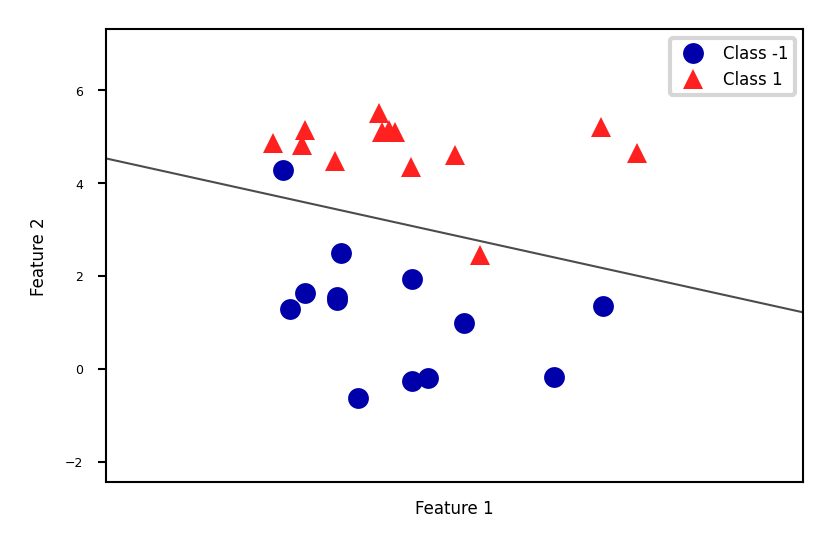

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

Xf, yf = mglearn.datasets.make_forge()
fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
clf = LogisticRegression().fit(Xf, yf)
mglearn.tools.plot_2d_separator(clf, Xf,
                                ax=ax, alpha=.7, cm=mglearn.cm2)
mglearn.discrete_scatter(Xf[:, 0], Xf[:, 1], yf, ax=ax, s=10*fig_scale)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend(['Class -1','Class 1']);

* Hay muchos algoritmos para la clasificación lineal, que difieren en la función de pérdida, las técnicas de regularización y el método de optimización.


* Técnicas más comunes:
    * Convertir las clases objetivo {neg,pos} a {0,1} y resolver como problema de regresión
        * Regresión Logística (Log loss)
        * Ridge Classification (Least Squares + L2 loss)
    * Encuentre un hiperplano que maximice el margen entre clases
        * Linear Support Vector Machines (Hinge loss)
    * Redes Neuronales sin función de activación
        * Perceptron (Perceptron loss)
    * SGDClassifier: puede actuar como cualquiera de estos eligiendo la función de pérdida adecuada. 
        * Hinge, Log, Modified_huber, Squared_hinge, Perceptron

### Regresión Logística
* Tiene como objetivo predecir la probabilidad de que un punto pertenezca a alguna clase. 
* Convierte valores objetivo {negativo (azul), positivo (rojo)} a {0,1}
* Fija una función logística (o sigmoide o _S_ curve) a travéz de estos puntos.
    * Mapea $(-\infty, \infty)$ to a probability [0,1]
    
    $$ \hat{y} = \textrm{logistic}(f_{\theta}(\mathbf{x})) = \frac{1}{1+e^{-f_{\theta}(\mathbf{x})}} $$
    
* E.g. en 1D: $ \textrm{logistic}(x_1w_1+w_0) = \frac{1}{1+e^{-x_1w_1-w_0}} $

In [3]:
def sigmoid(x,w1,w0):
    return 1 / (1 + np.exp(-(x*w1+w0)))

def plot_logreg(w0=(-10.0,5.0,1),w1=(-1.0,3.0,0.3)):
    fig, ax = plt.subplots(figsize=(8*fig_scale,3*fig_scale))
    red = [Xf[i, 1] for i in range(len(yf)) if yf[i]==1]
    blue = [Xf[i, 1] for i in range(len(yf)) if yf[i]==0]
    ax.scatter(red, [1]*len(red), c='r', label='Positive class')
    ax.scatter(blue, [0]*len(blue), c='b', label='Negative class')
    x = np.linspace(min(-1, -w0/w1),max(6, -w0/w1))
    ax.plot(x,sigmoid(x,w1,w0),lw=2*fig_scale,c='g', label='logistic(x*w1+w0)'.format(np.round(w0,2),np.round(w1,2)))
    ax.axvline(x=(-w0/w1), ymin=0, ymax=1, label='Decision boundary')
    ax.plot(x,x*w1+w0,lw=2*fig_scale,c='k',linestyle=':', label='y=x*w1+w0')
    ax.set_xlabel("Feature")
    ax.set_ylabel("y")
    ax.set_ylim(-0.05,1.05)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);

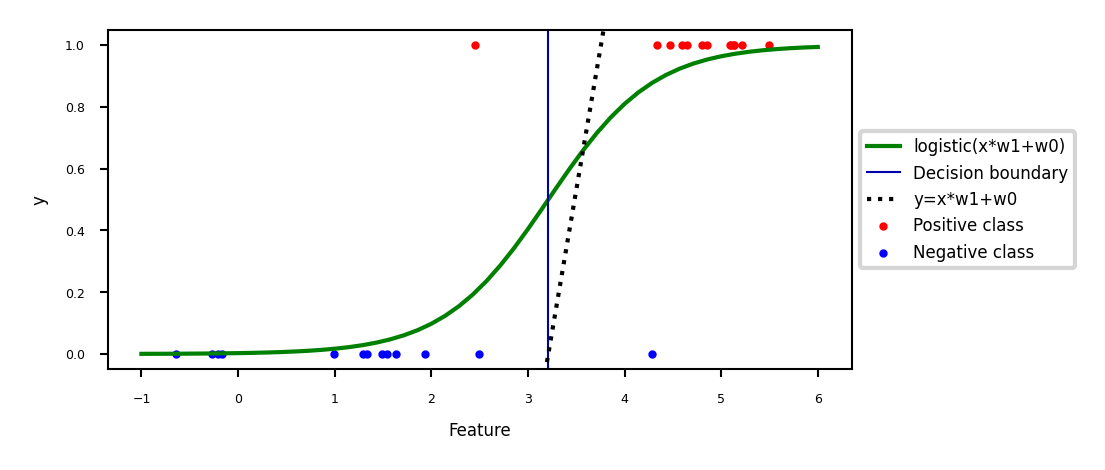

In [4]:
clf2 = LogisticRegression(C=100).fit(Xf[:, 1].reshape(-1, 1), yf)
w0 = clf2.intercept_
w1 = clf2.coef_[0][0]
plot_logreg(w0=w0,w1=w1)

* Solución ajustada a nuestro ejemplo 2D:
    * Para obtener una predicción binaria, elija un umbral de probabilidad (por ejemplo, 0,5)

In [5]:
lr_clf = LogisticRegression(C=100).fit(Xf, yf)

def sigmoid2d(x1,x2,w0,w1,w2):
    return 1 / (1 + np.exp(-(x2*w2+x1*w1+w0)))

def plot_logistic_fit(rotation=(0,360,10)):
    w0 = lr_clf.intercept_
    w1 = lr_clf.coef_[0][0]
    w2 = lr_clf.coef_[0][1]

    # plot surface of f
    fig = plt.figure(figsize=(7*fig_scale,5*fig_scale))
    ax = plt.axes(projection="3d")
    x0 = np.linspace(8, 16, 30)
    x1 = np.linspace(-1, 6, 30)
    X0, X1 = np.meshgrid(x0, x1)
    
    # Surface
    ax.plot_surface(X0, X1, sigmoid2d(X0, X1, w0, w1, w2), rstride=1, cstride=1,
                    cmap='bwr', edgecolor='none',alpha=0.5,label='sigmoid')
    # Points
    c=['b','r']
    ax.scatter3D(Xf[:, 0], Xf[:, 1], yf, c=[c[i] for i in yf], s=10*fig_scale)
    
    # Decision boundary
    # x2 = -(x1*w1 + w0)/w2
    ax.plot3D(x0,-(x0*w1 + w0)/w2,[0.5]*len(x0), lw=1*fig_scale, c='k', linestyle=':')
    z = np.linspace(0, 1, 31)
    XZ, Z = np.meshgrid(x0, z)
    YZ = -(XZ*w1 + w0)/w2    
    ax.plot_wireframe(XZ, YZ, Z, rstride=5, lw=1*fig_scale, cstride=5, alpha=0.3, color='k',label='decision boundary')
    ax.tick_params(axis='both', width=0, labelsize=10*fig_scale, pad=-4)

    ax.set_xlabel('x0', labelpad=-6)
    ax.set_ylabel('x1', labelpad=-6)
    ax.get_zaxis().set_ticks([])
    ax.view_init(30, rotation) # Use this to rotate the figure
    plt.tight_layout()
    #plt.legend() # Doesn't work yet, bug in matplotlib
    plt.show()

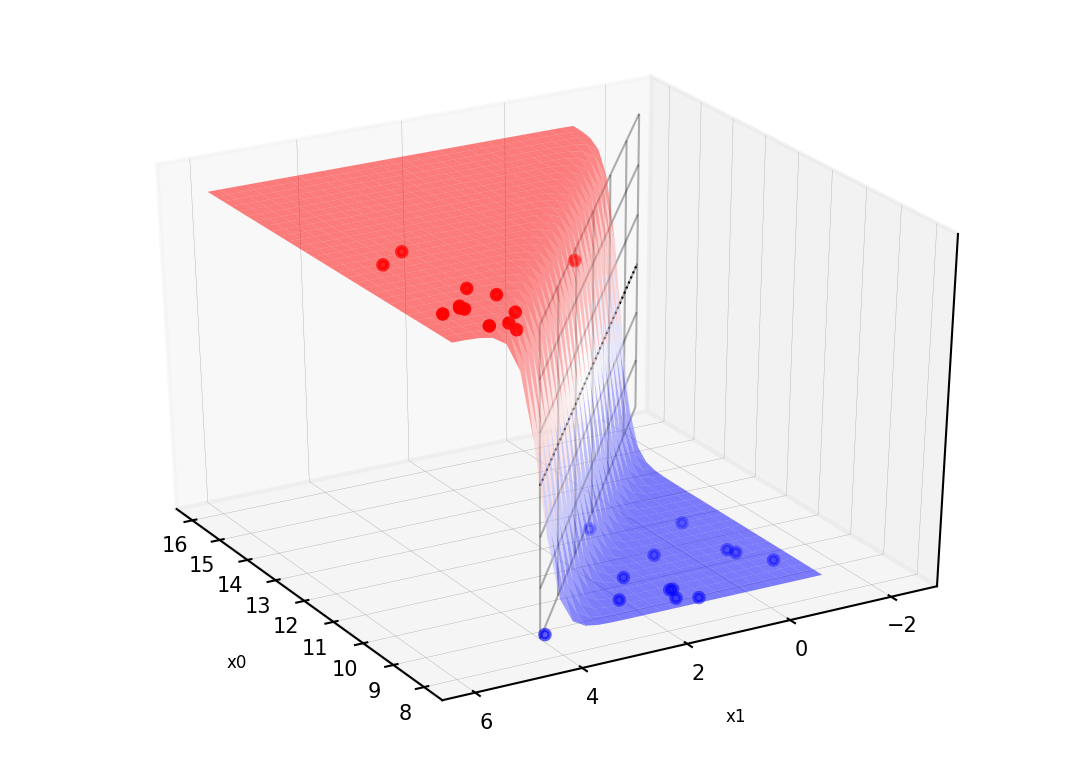

In [6]:
plot_logistic_fit(rotation=150)

#### En práctica 
* La regresión logística también se puede encontrar en `sklearn.linear_model`.
    * `C` hiperparámetro es la fuerza de regularización _inversa_: $C=\alpha^{-1}$
    * `penalty`: tipo de regularización: L1, L2 (predeterminado), Elastic-Net o Ninguno.
    * `solver`: newton-cg, lbfgs (default), liblinear, sag, saga
* Si se incremente C: menos regularización, trata de sobreajustar puntos individuales

``` python
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1).fit(X_train, y_train)
```

In [7]:
from sklearn.linear_model import LogisticRegression

def plot_lr(C_log=(-3,4,0.1)):
    # Still using artificial data
    fig, ax = plt.subplots(figsize=(6*fig_scale,3*fig_scale))
    mglearn.discrete_scatter(Xf[:, 0], Xf[:, 1], yf, ax=ax, s=10*fig_scale)
    lr = LogisticRegression(C=10**C_log).fit(Xf, yf)
    w = lr.coef_[0]
    xx = np.linspace(7, 13)
    yy = (-w[0] * xx - lr.intercept_[0]) / w[1]
    ax.plot(xx, yy, c='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title("C = {:.3f}, w1={:.3f}, w2={:.3f}".format(10**C_log,w[0],w[1]))
    ax.legend(loc="best");

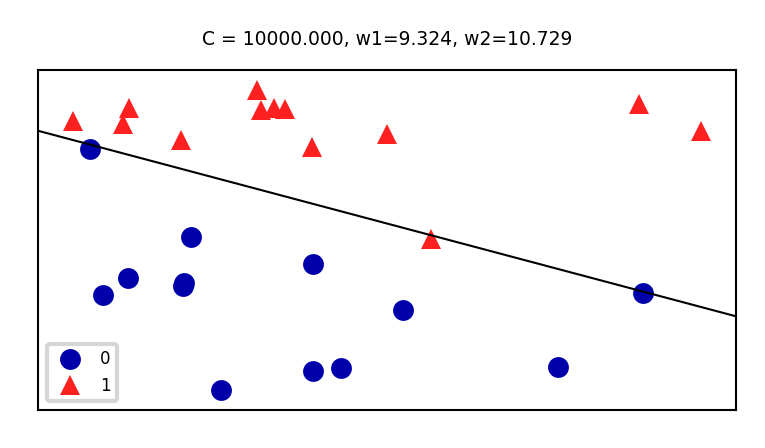

In [8]:
plot_lr(C_log=(4))

* Analizar el comportamiento en el conjunto de datos de cáncer de mama
    * Underfitting si C es muy pequeña, algo de overfitting si C es demasiado grande.
    * Usamos cross-validation porque el dataset es pequeño.

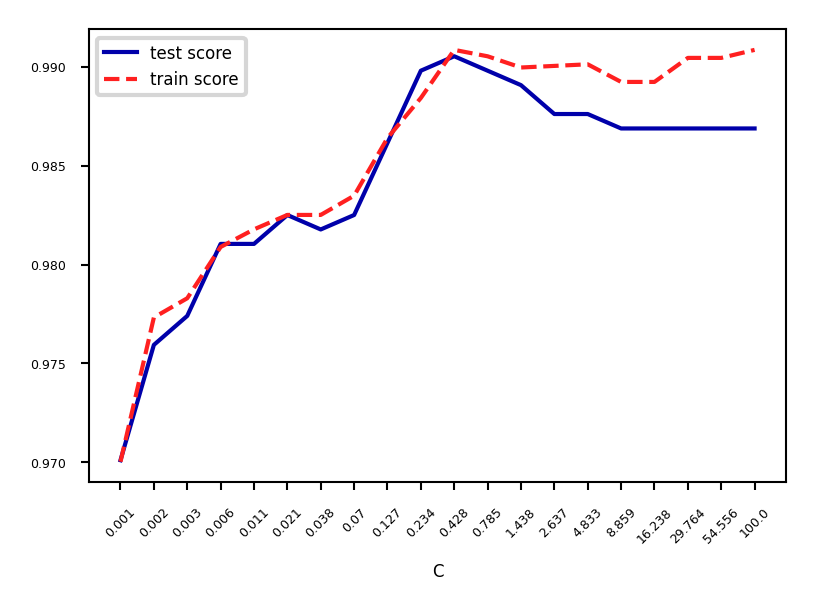

In [9]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_validate

spam_data = fetch_openml(name="banknote-authentication", as_frame=True)
X_C, y_C = spam_data.data, spam_data.target

C=np.logspace(-3,2,num=20)
test_score=[]
train_score=[]
for c in C:
    lr = LogisticRegression(C=c)
    scores = cross_validate(lr,X_C,y_C,cv=10, return_train_score="True")
    test_score.append(np.mean(scores['test_score']))
    train_score.append(np.mean(scores['train_score']))
fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
ax.set_xticks(range(20))
ax.set_xticklabels(np.round(C,3))
ax.set_xlabel('C')
ax.plot(test_score, lw=2*fig_scale, label='test score')
ax.plot(train_score, lw=2*fig_scale, label='train score')
ax.legend()
plt.xticks(rotation=45);

### Máquinas de Soporte Vectorial
- Los límites de decisión cercanos a los puntos de entrenamiento pueden generalizarse mal
    - Los puntos de prueba muy similares (cercanos) se clasifican como la otra clase
- Elegir un límite que esté lo más lejos posible de los puntos de entrenamiento
- Los __support vectors__ son las muestras de entrenamiento más cercanas al hiperplano.
- El __margin__ 
es la distancia entre el hiperplano de separación y los _support vectors_
- El objetivo es maximizar _margin_
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/05_margin.png" alt="ml" style="width: 1250px;"/>

#### Efecto de la regularización sobre los vectores de margen y soporte
- SVM's Hinge loss actua como regularización L1, produce modelos dispersos
- C es la fuerza de regularización inversa (la inversa de $\alpha$ en Lasso)
    - C grande: menos vectores de soporte, menor margen, más sobreajuste
    - C pequeña: más vectores de soporte, mayor margen, menos sobreajuste
- Debe ajustarse cuidadosamente a los datos.

Los valores grandes de C pueden dar lugar a un ajuste excesivo (p. ej., ruido de ajuste), los valores pequeños pueden dar lugar a un ajuste insuficiente

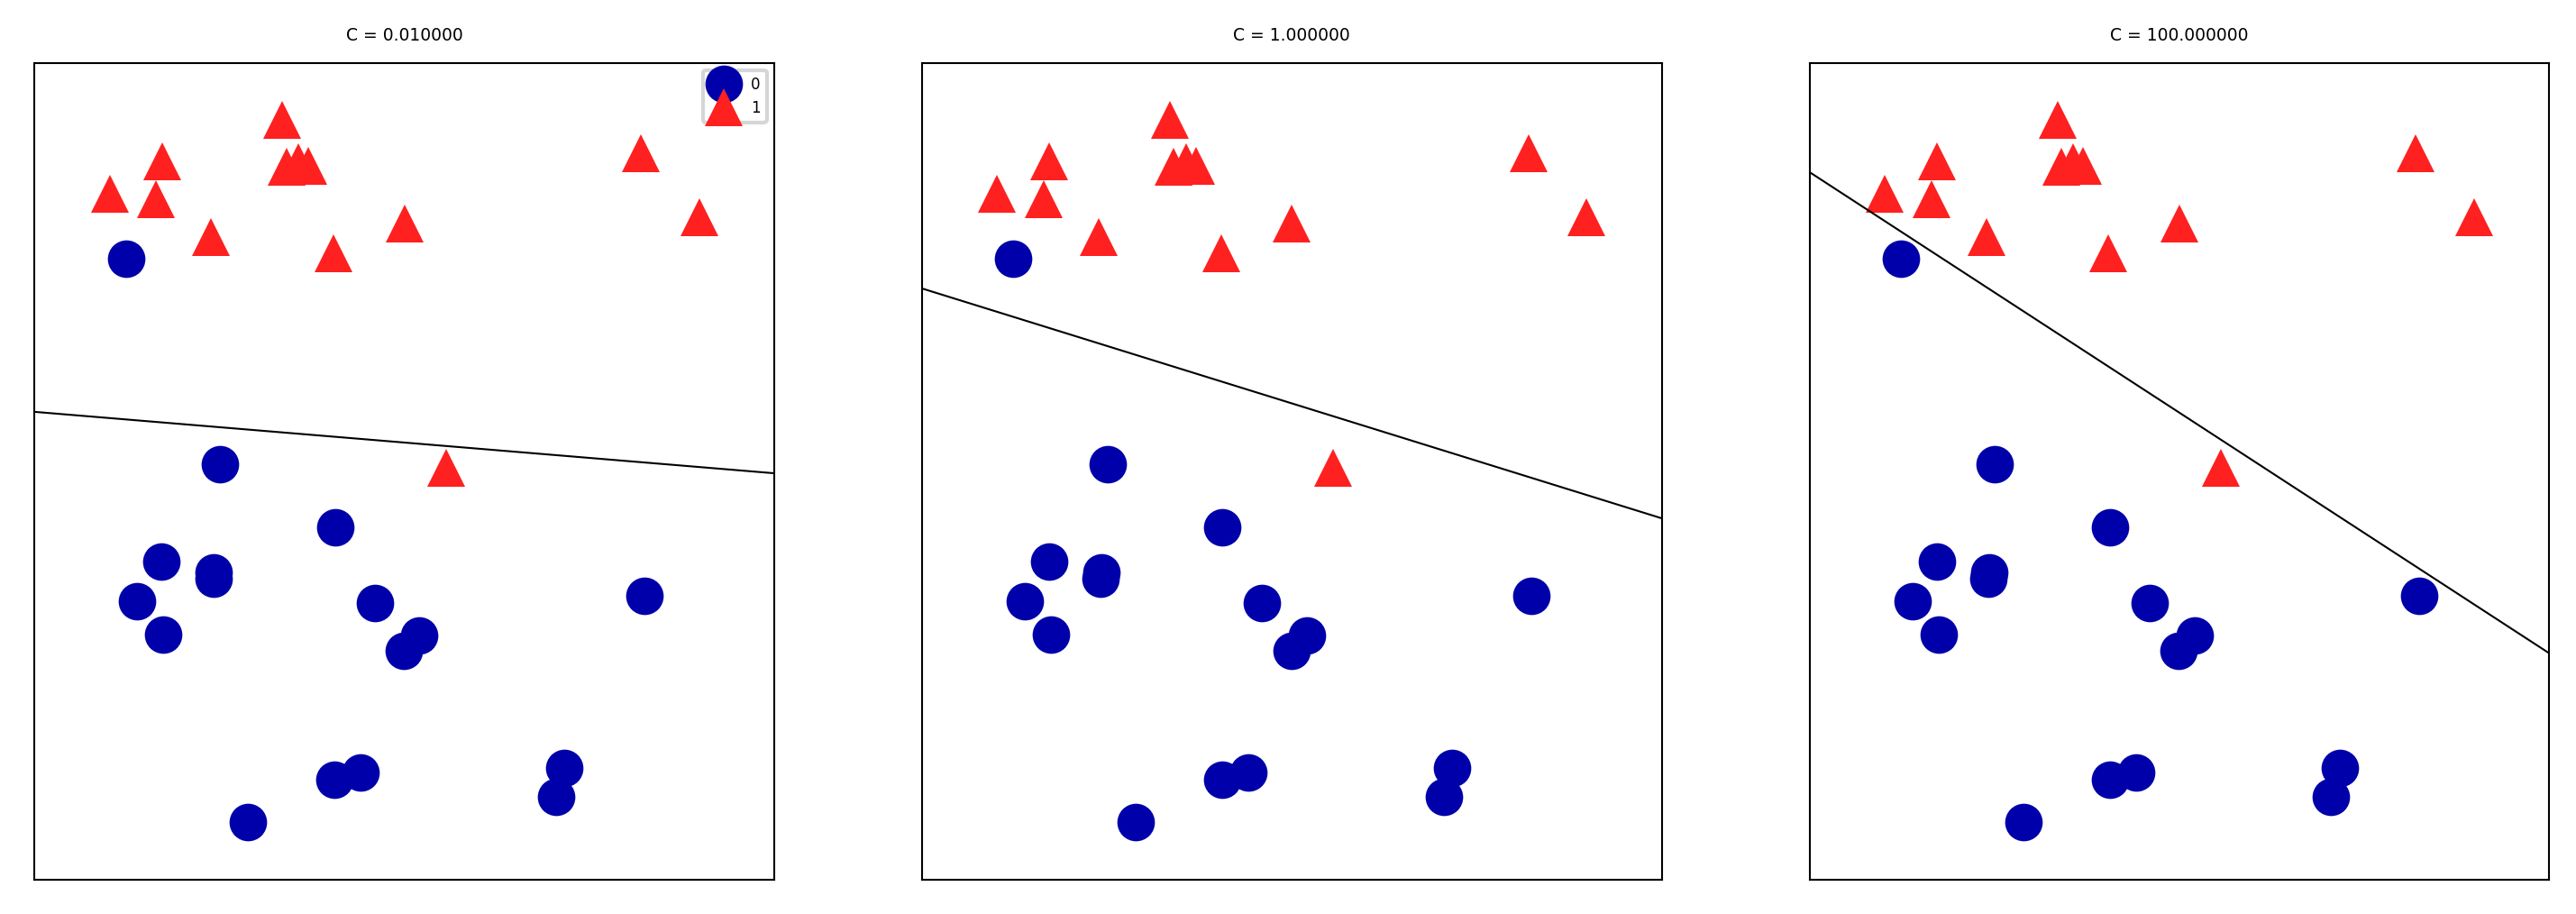

In [17]:
mglearn.plots.plot_linear_svc_regularization()

#### En práctica SVMs in scikit-learn

- `svm.LinearSVC`: Más rapido para grandes conjuntos de datos. 
    - Permite las opciones primal o dual. Primal es recomendado cuando $n$ >> $p$ (observaciones >> características )
    - Retorna `coef_` ($\mathbf{w}$) y `intercept_` ($w_0$)
- `svm.SVC` con `kernel=linear`: permite _kernelización_ (see later)
    - También retorna `support_vectors_` y  `dual_coef_` $a_i$
    - Escala al menos cuadráticamente con el número de muestras $n$
    
``` python
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)
print("Support vectors:", clf.support_vectors_[:])
print("Coefficients:", clf.dual_coef_[:])
```

In [18]:
from sklearn import svm

# Linearly separable dat
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

# Fit the model
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)

# Get the support vectors and weights
print("Support vectors:")
print(clf.support_vectors_[:])
print("Coefficients:")
print(clf.dual_coef_[:])

Support vectors:
[[-1.021  0.241]
 [-0.467 -0.531]
 [ 0.951  0.58 ]]
Coefficients:
[[-0.048 -0.569  0.617]]


## Modelos lineales para problemas multi-clase


---



### one-vs-rest (aka one-vs-all)

* Aprenda un modelo binario para cada clase frente a todas las demás clases
* Crea tantos modelos binarios como clases haya.

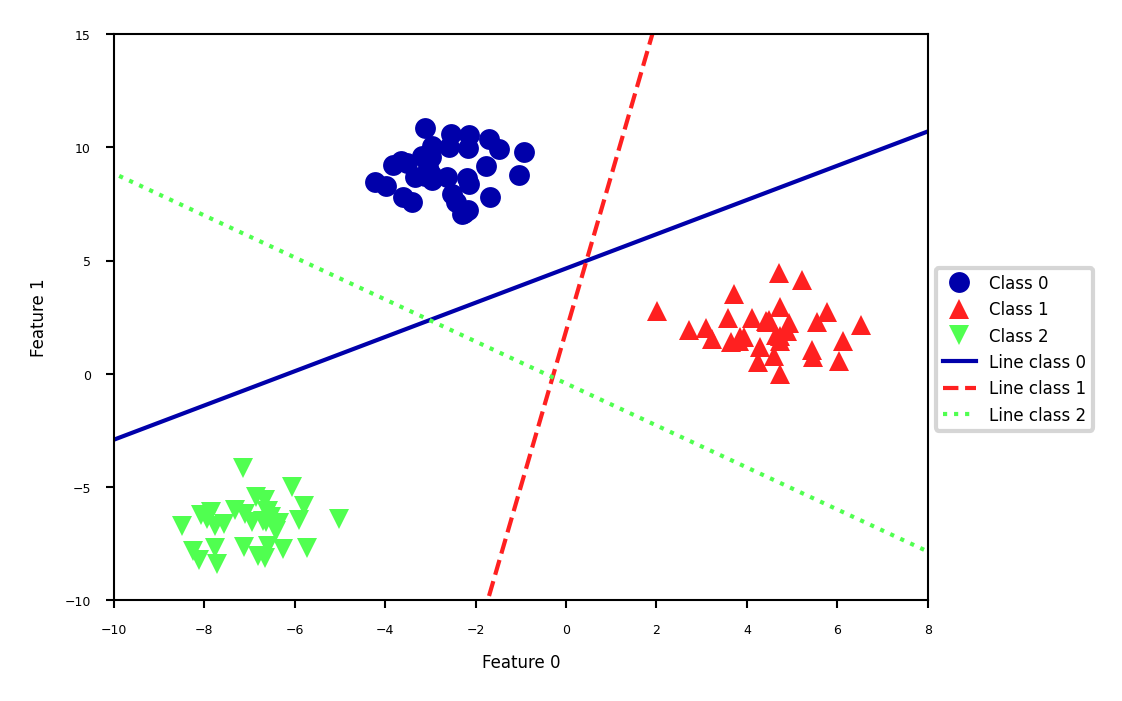

In [19]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state=42)
linear_svm = LinearSVC().fit(X, y)

plt.rcParams["figure.figsize"] = (7*fig_scale,5*fig_scale)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, s=10*fig_scale)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color, lw=2*fig_scale)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3));

* Cada clasificador binario hace una predicción, el que tiene la puntuación más alta (>0) gana

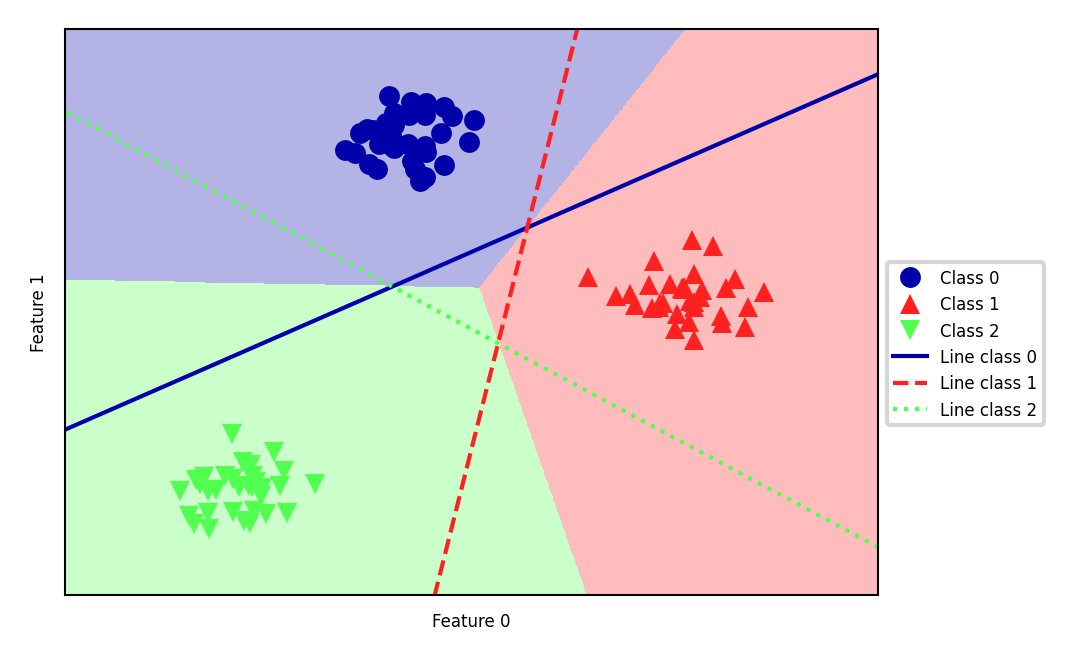

In [20]:
mglearn.plots.plot_2d_classification(linear_svm, X, fill=True, alpha=0.3)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, s=10*fig_scale)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color, lw=2*fig_scale)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

### one-vs-one
* Una alternativa es aprender un modelo binario para cada _combinación_ de dos clases
    * Para $C$ classes, esto resulta en $\frac{C(C-1)}{2}$ modelos binarios
    * Cada punto se clasifica según un voto mayoritario entre todos los modelos.
    * También puede ser un 'soft vote': sume las probabilidades (o valores de decisión) para todos los modelos. La clase con la suma más alta gana.

* Requiere más modelos que *one-vs-rest*, pero entrenar a cada uno es más rápido
    * Solo los ejemplos de 2 clases están incluidos en los datos de entrenamiento
* Recomendado para algoritmos que aprenden bien en conjuntos de datos pequeños
    * Especialmente SVM y procesos gaussianos

# Referencias 

* Welcome — ML Engineering. (s. f.). https://ml-course.github.io/master/intro.html

* Topic 4. Linear Classification and Regression — mlcourse.ai. (s. f.). https://mlcourse.ai/book/topic04/topic4_linear_models_part2_logit_likelihood_learning.html

* Banoula, M. (2023, 15 febrero). The Best Guide to Regularization in Machine Learning. Simplilearn.com. https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning
